# Hyperparameter Tuning for Random Forest Classifier (One vs. All)

In [3]:
# import libraries
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_theme(style="whitegrid")

In [4]:
# import data
df = pd.read_csv('data/tracks_1000Unique+_with_duplicates.csv', index_col=False)
df.drop(columns={'Unnamed: 0'}, inplace=True)

In [5]:
del df["track_id"]; del df["artist_name"]; del df["track_name"]

In [6]:
# Make it 1000 for each category
result = df.groupby("genre").apply(lambda x: x.head(1000)).reset_index(drop=True)
result

,genre,popularity,duplicated_x,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,duplicated_y
0,blues,87.0,True,0.352,0.911,1,-5.230,1,0.0747,0.001210,0.000000,0.0995,0.236,148.033,222973,4,False
1,blues,94.0,True,0.464,0.417,0,-9.345,0,0.0256,0.136000,0.022000,0.0974,0.479,67.528,183956,4,False
2,blues,85.0,True,0.640,0.663,0,-7.516,1,0.0374,0.201000,0.008060,0.1520,0.663,132.770,140773,4,False
3,blues,87.0,True,0.640,0.740,4,-4.083,1,0.0284,0.011500,0.006780,0.1670,0.785,116.879,216320,4,False
4,blues,80.0,True,0.636,0.676,2,-3.442,1,0.0263,0.080700,0.000000,0.0831,0.273,113.980,208760,4,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,techno,29.0,False,0.732,0.875,4,-5.842,0,0.0326,0.126000,0.000234,0.2200,0.933,132.987,214960,4,False
9996,techno,49.0,False,0.738,0.816,4,-6.304,0,0.0322,0.000877,0.785000,0.1340,0.884,129.998,198793,4,False
9997,techno,35.0,False,0.610,0.875,5,-5.455,0,0.0333,0.028300,0.908000,0.1140,0.873,144.999,309023,4,False
9998,techno,44.0,False,0.756,0.527,8,-11.861,1,0.0428,0.002010,0.509000,0.1120,0.248,119.996,416500,4,False


## Training Preparation & Scaling

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

y_tmp = pd.DataFrame(result["genre"])
X = result.drop("genre", axis=1)
encoder = OneHotEncoder(sparse=False)
encoder.fit(y_tmp)
cols = [x.replace("x0_", "") for x in encoder.get_feature_names_out()]
display(len(cols))
y = pd.DataFrame(encoder.transform(y_tmp), columns=cols)
X_train_org, X_test_org, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)# , stratify=y > 0

/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


10

In [8]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer

def scaler_pipeline():
    return make_pipeline(SimpleImputer(strategy='constant', fill_value=0), RobustScaler())

def scaler_pipeline_pwr():
    return make_pipeline(SimpleImputer(strategy='constant', fill_value=0), RobustScaler(), PowerTransformer(method='yeo-johnson', standardize=True))

ct = ColumnTransformer([
        ('stdscaled', StandardScaler(), ["popularity","danceability","energy","key","loudness","mode","speechiness","acousticness","instrumentalness","liveness","valence","tempo","duration_ms","time_signature"]),
       ], remainder='passthrough')

X_train_scaled = ct.fit_transform(X_train_org)
X_test_scaled  = ct.transform(X_test_org)
X_train = X_train_scaled
X_test  = X_test_scaled

## Examine Parameters and Influences

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

### Number of Trees in Forest

In [10]:
n_trees = [10, 50, 100, 500, 1000]
cv_scores = {
    'genre': [],
    'n_trees': [],
    'score': []
}

for gen in y_train.columns:
    print('Genre:\t', gen)
    for n_estimator in n_trees:
        _model = RandomForestClassifier(n_estimator)
        _model.fit(X_train, y_train[gen])
        cv = cross_val_score(_model, X_train, y_train[gen], cv=3, scoring='accuracy')
        print('Cross validation score for {} estimator -> \t {}'.format(n_estimator, cv))
        cv_scores['genre'].append(gen)
        cv_scores['n_trees'].append(n_estimator)
        cv_scores['score'].append(cv)
    print('')

cv_scores_df = pd.DataFrame.from_dict(cv_scores)

Genre:	 genre_blues
Cross validation score for 10 estimator -> 	 [0.88601425 0.89351331 0.89047262]
Cross validation score for 50 estimator -> 	 [0.89951256 0.88938883 0.89647412]
Cross validation score for 100 estimator -> 	 [0.90176228 0.90063742 0.89834959]
Cross validation score for 500 estimator -> 	 [0.90251219 0.90288714 0.89834959]
Cross validation score for 1000 estimator -> 	 [0.904012   0.90288714 0.89984996]

Genre:	 genre_classical
Cross validation score for 10 estimator -> 	 [0.87776528 0.88188976 0.87171793]
Cross validation score for 50 estimator -> 	 [0.88038995 0.88713911 0.88334584]
Cross validation score for 100 estimator -> 	 [0.88301462 0.8927634  0.88897224]
Cross validation score for 500 estimator -> 	 [0.88788901 0.89688789 0.89572393]
Cross validation score for 1000 estimator -> 	 [0.88976378 0.89876265 0.89422356]

Genre:	 genre_electronic
Cross validation score for 10 estimator -> 	 [0.85076865 0.856018   0.86234059]
Cross validation score for 50 estimator -

In [11]:
def plot_validations(cv_scores, x_label, x_ticklabels, genre):
    plt.figure(figsize=(len(x_ticklabels),4))
    plt.title(genre)
    ax = sns.boxplot(data=cv_scores)
    ax.set_xticklabels(x_ticklabels)
    ax.set_ylabel('accuracy')
    ax.set_xlabel(x_label);

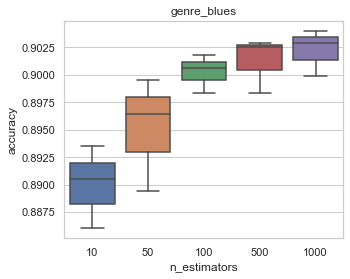

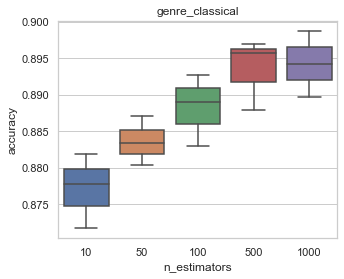

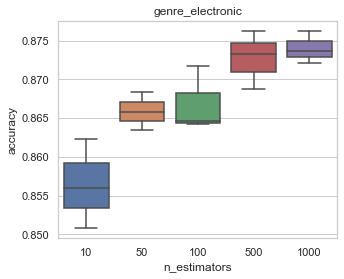

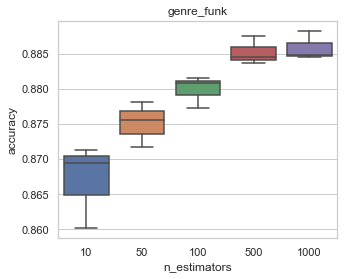

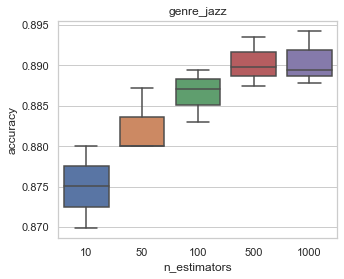

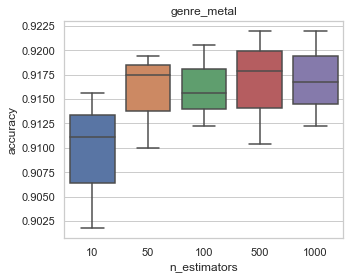

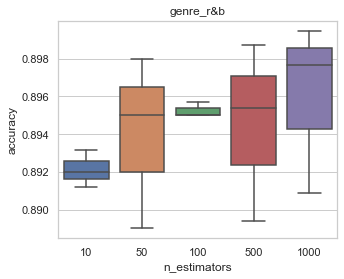

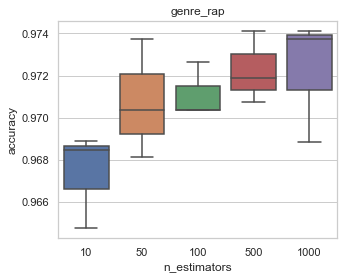

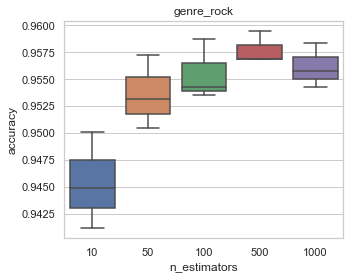

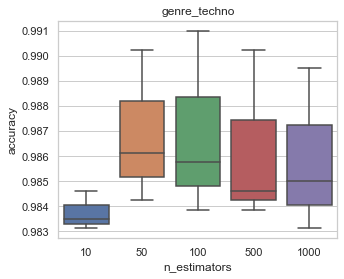

In [12]:
for genre in y_train.columns:
    plot_validations(cv_scores_df[cv_scores_df['genre']==genre]['score'].tolist(), 'n_estimators', n_trees, genre)

### Max Tree Depth

In [13]:
max_depths = range(1,8)

cv_scores_max_depth = {
    'genre': [],
    'tree_depth': [],
    'score': []
}

for genre in y_train.columns:
    print('Genre:\t', genre)
    for depth in max_depths:
        _model = RandomForestClassifier(max_depth=depth, random_state=42)
        _model.fit(X_train, y_train[genre])
        cv = cross_val_score(_model, X_train, y_train[genre], cv=3, scoring='accuracy')
        print('Cross validation score for max tree depth of {} -> \t {}'.format(depth, cv))
        cv_scores_max_depth['genre'].append(genre)
        cv_scores_max_depth['tree_depth'].append(depth)
        cv_scores_max_depth['score'].append(cv)
    print('')

cv_scores_max_depth_df = pd.DataFrame.from_dict(cv_scores_max_depth)

Genre:	 genre_blues
Cross validation score for max tree depth of 1 -> 	 [0.90101237 0.90101237 0.90097524]
Cross validation score for max tree depth of 2 -> 	 [0.90101237 0.90101237 0.90097524]
Cross validation score for max tree depth of 3 -> 	 [0.90101237 0.90101237 0.90097524]
Cross validation score for max tree depth of 4 -> 	 [0.90101237 0.90101237 0.90097524]
Cross validation score for max tree depth of 5 -> 	 [0.90101237 0.90101237 0.90097524]
Cross validation score for max tree depth of 6 -> 	 [0.90213723 0.90288714 0.90135034]
Cross validation score for max tree depth of 7 -> 	 [0.90663667 0.90551181 0.90247562]

Genre:	 genre_classical
Cross validation score for max tree depth of 1 -> 	 [0.90326209 0.90513686 0.90585146]
Cross validation score for max tree depth of 2 -> 	 [0.90588676 0.90588676 0.90735184]
Cross validation score for max tree depth of 3 -> 	 [0.90888639 0.90738658 0.90885221]
Cross validation score for max tree depth of 4 -> 	 [0.9096363  0.90738658 0.90922731

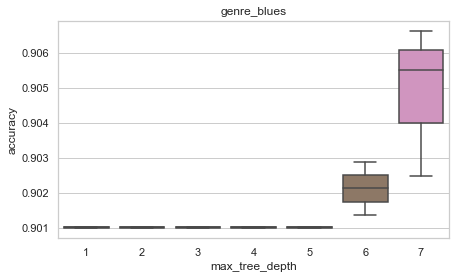

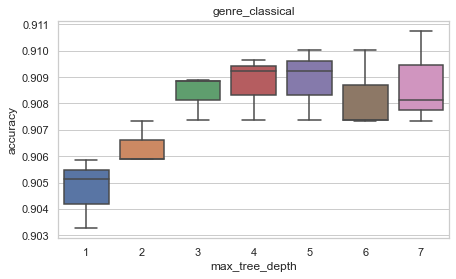

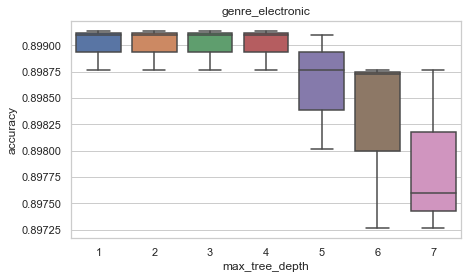

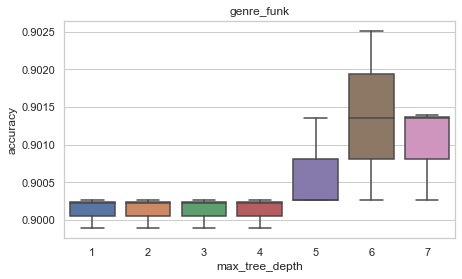

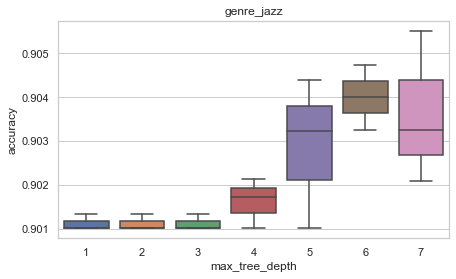

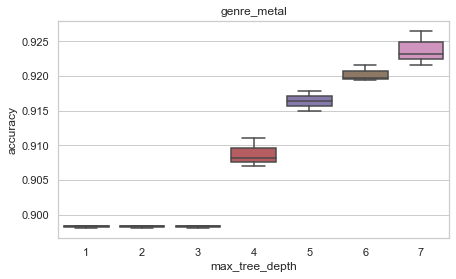

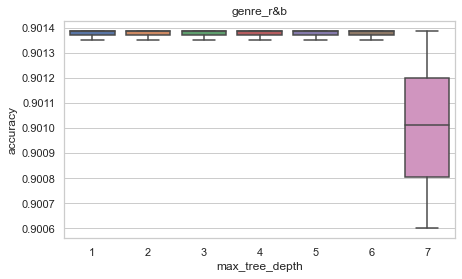

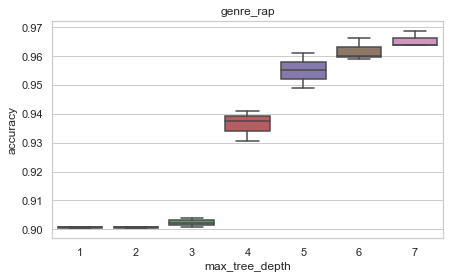

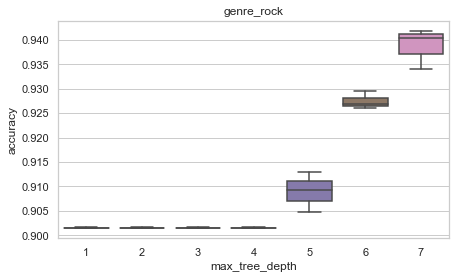

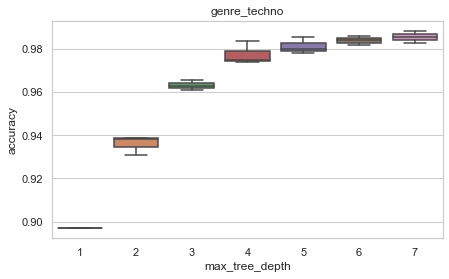

In [14]:
for genre in y_train.columns:
    plot_validations(cv_scores_max_depth_df[cv_scores_max_depth_df['genre']==genre]['score'].tolist(), 'max_tree_depth', max_depths, genre)

### Max Features in Model

In [15]:
n_max_features = range(1, X.shape[1])
cv_scores_max_features = {
    'genre': [],
    'n_features': [],
    'score': []
}

for genre in y_train.columns:
    print('Genre:\t', genre)
    for n_features in n_max_features:
        _model = RandomForestClassifier(max_features=n_features, random_state=42)
        _model.fit(X_train, y_train[genre])
        cv = cross_val_score(_model, X_train, y_train[genre], cv=3, scoring='accuracy')
        print('Cross validation score for max number of features {} -> \t {}'.format(n_features, cv))
        cv_scores_max_features['genre'].append(genre)
        cv_scores_max_features['n_features'].append(n_features)
        cv_scores_max_features['score'].append(cv)

cv_scores_max_features_df = pd.DataFrame.from_dict(cv_scores_max_features)

Genre:	 genre_blues
Cross validation score for max number of features 1 -> 	 [0.89351331 0.88976378 0.88822206]
Cross validation score for max number of features 2 -> 	 [0.89688789 0.89163855 0.88934734]
Cross validation score for max number of features 3 -> 	 [0.89613798 0.89726284 0.89684921]
Cross validation score for max number of features 4 -> 	 [0.89988751 0.90213723 0.89572393]
Cross validation score for max number of features 5 -> 	 [0.89988751 0.90101237 0.89647412]
Cross validation score for max number of features 6 -> 	 [0.90213723 0.90551181 0.89647412]
Cross validation score for max number of features 7 -> 	 [0.90288714 0.90626172 0.89834959]
Cross validation score for max number of features 8 -> 	 [0.89988751 0.90551181 0.89722431]
Cross validation score for max number of features 9 -> 	 [0.9047619 0.9047619 0.8975994]
Cross validation score for max number of features 10 -> 	 [0.90251219 0.90551181 0.89947487]
Cross validation score for max number of features 11 -> 	 [0.9

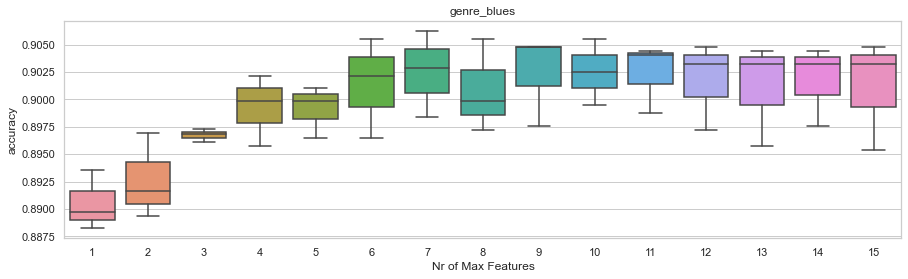

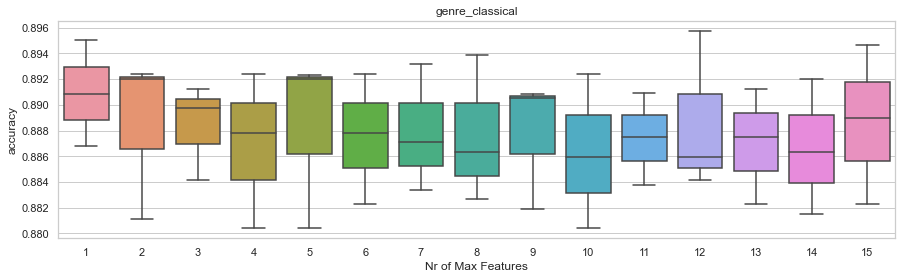

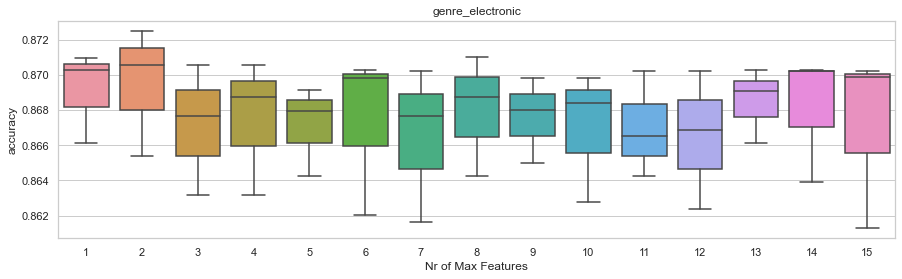

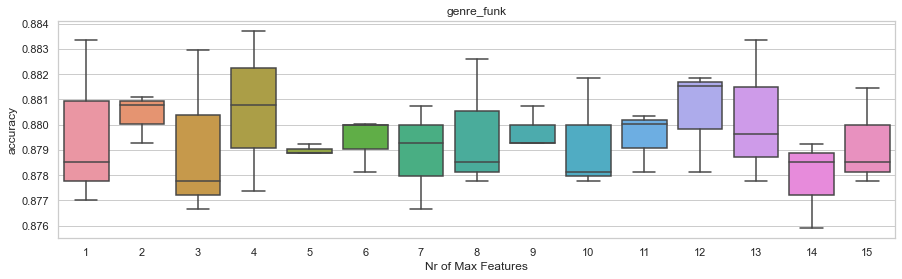

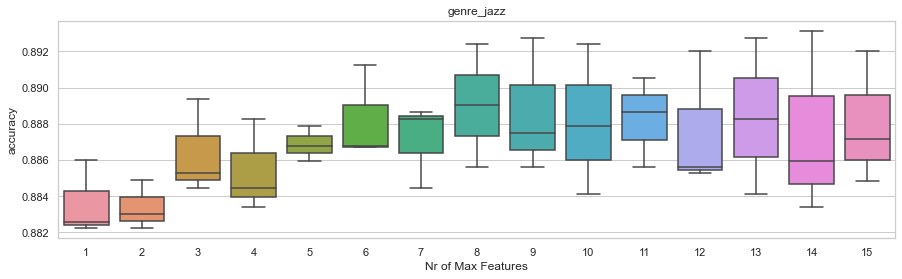

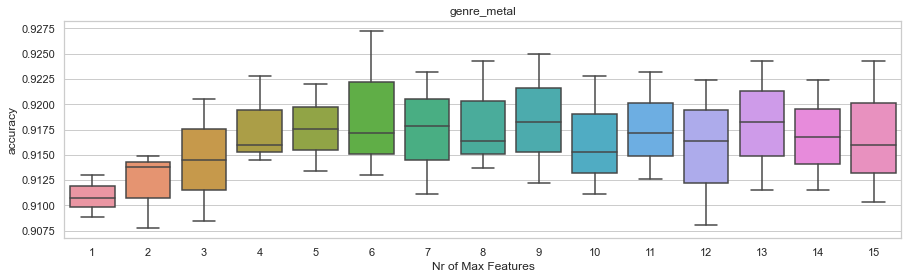

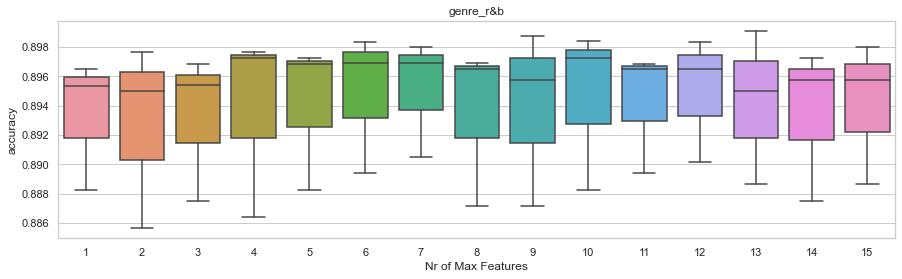

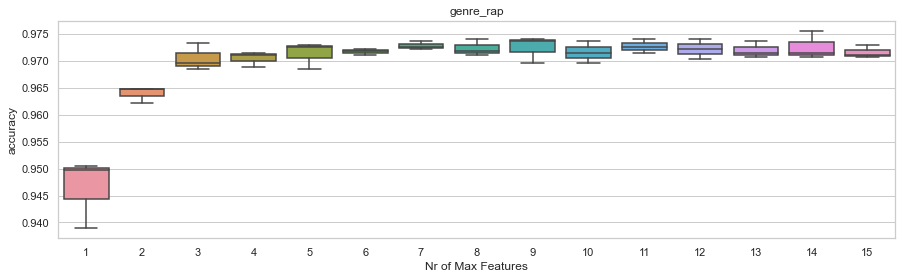

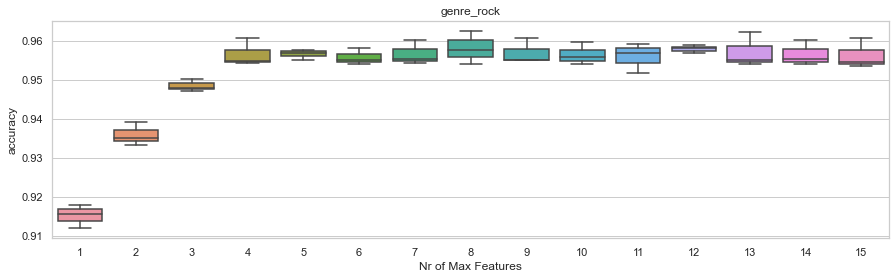

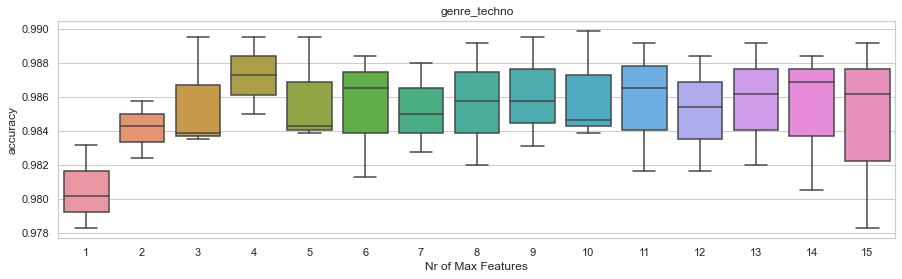

In [16]:
for genre in y_train.columns:
    plot_validations(cv_scores_max_features_df[cv_scores_max_features_df['genre']==genre]['score'].tolist(), 'Nr of Max Features', n_max_features, genre)

- Each genre has slight different cross validation scores based on the number of maximum features.
- Mostly number of features greater than 7 or 8 doesn't show a huge improvement.
- In general, there is a performance gap of ~2% between the best and worst. Ultimately changing the number of features don't make drastic changes.

### Optimize parameters of random forest classifier with RandomSearch

In [17]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

In [18]:
rfc = RandomForestClassifier() # model to be optimized

# parameters to be optimized
params_grid = {
    'n_estimators': n_trees,
    'max_features': n_max_features,
    'max_depth': max_depths
}

# tuning parameters
n_iter = 100
cv = KFold(3, random_state=42, shuffle=True)
n_jobs = -1
scoring = 'accuracy'

In [85]:
rfc_randomized_search = {
    'genre': [],
    'test-accuracy': []
}

start = time.time()
for genre in y_train.columns:
    print('Randomized Search for:\t ', genre)
    loop_start = time.time()
    _model = RandomForestClassifier(random_state=42)
    _random_search = RandomizedSearchCV(_model, params_grid, n_iter=n_iter, cv=cv, n_jobs=n_jobs, scoring=scoring, random_state=42, verbose=3)
    _random_search.fit(X_train, y_train[genre])
    _predictions = _random_search.best_estimator_.predict(X_test)
    _test_accuracy = round(accuracy_score(y_test[genre], _predictions), 4) * 100
    rfc_randomized_search['genre'].append(genre)
    rfc_randomized_search['test-accuracy'].append(_test_accuracy)
    print(f'Test set Accuracy:\t {_test_accuracy}%.')
    loop_duration = round(time.time() - loop_start)
    print('Genre:\t', genre, '\nComputation time:\t', loop_duration, ' seconds')
    print('Best estimators:\t', _random_search.best_estimator_)
    print('')

end = round(time.time() - start)
print('##########################################')
print('Total process duration:\t', end, ' seconds')

Randomized Search for:	  genre_blues
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Test set Accuracy:	 90.8%.
Genre:	 genre_blues 
Computation time:	 77  seconds
Best estimators:	 RandomForestClassifier(max_depth=7, max_features=12, random_state=42)

Randomized Search for:	  genre_classical
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Test set Accuracy:	 90.4%.
Genre:	 genre_classical 
Computation time:	 72  seconds
Best estimators:	 RandomForestClassifier(max_depth=6, max_features=7, random_state=42)

Randomized Search for:	  genre_electronic
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Test set Accuracy:	 90.4%.
Genre:	 genre_electronic 
Computation time:	 53  seconds
Best estimators:	 RandomForestClassifier(max_depth=5, max_features=3, n_estimators=10,
                       random_state=42)

Randomized Search for:	  genre_funk
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Test set Accuracy:	 90.0%.
Genre:	 genre_

In [34]:
rfc_randomized_search_df = pd.DataFrame.from_dict(rfc_randomized_search)
rfc_randomized_search_df.genre = rfc_randomized_search_df.genre.str.replace('genre_', ' ')
rfc_randomized_search_df.sort_values(by='test-accuracy', ascending=False)

,genre,test-accuracy
9,techno,99.00
7,rap,96.80
8,rock,95.20
5,metal,93.25
0,blues,90.80
4,jazz,90.65
1,classical,90.40
2,electronic,90.40
3,funk,90.00
6,r&b,89.45


In [84]:
print(_random_search.best_estimator_)

RandomForestClassifier(max_depth=7, max_features=8, random_state=42)


## Compare performance with initial run

In [77]:
initial_training_accuracy = pd.read_csv('./data/model_performance_1k.csv', index_col=0)
initial_training_accuracy

,blues,classical,electronic,funk,jazz,metal,r&b,rap,rock,techno
LogisticRegression,0.8960,0.9785,0.9025,0.9045,0.8940,0.905,0.8945,0.9250,0.9075,0.9420
KNeighborsClassifier,0.8925,0.9780,0.9045,0.9015,0.9080,0.904,0.8770,0.9155,0.8885,0.9390
DecisionTreeClassifier,0.8745,0.9640,0.8765,0.8725,0.8800,0.900,0.8520,0.9005,0.8925,0.9425
RandomForestClassifier,0.9130,0.9825,0.9170,0.9245,0.9195,0.942,0.9000,0.9340,0.9155,0.9635
SVC,0.8965,0.9825,0.9040,0.9070,0.9110,0.907,0.8950,0.9320,0.9050,0.9520


In [78]:
rfc_initial_training_accuracy = initial_training_accuracy[initial_training_accuracy.index.isin(['RandomForestClassifier'])]

In [79]:
rfc_initial_training_accuracy

,blues,classical,electronic,funk,jazz,metal,r&b,rap,rock,techno
RandomForestClassifier,0.913,0.9825,0.917,0.9245,0.9195,0.942,0.9,0.934,0.9155,0.9635


In [80]:
rfc_initial_training_melted = rfc_initial_training_accuracy.reset_index(drop=False).melt(id_vars=['index'], var_name='genre', value_name='test-accuracy').rename(columns={'index':'genre'})
rfc_initial_training_melted

,genre,genre,test-accuracy
0,RandomForestClassifier,blues,0.9130
1,RandomForestClassifier,classical,0.9825
2,RandomForestClassifier,electronic,0.9170
3,RandomForestClassifier,funk,0.9245
4,RandomForestClassifier,jazz,0.9195
5,RandomForestClassifier,metal,0.9420
6,RandomForestClassifier,r&b,0.9000
7,RandomForestClassifier,rap,0.9340
8,RandomForestClassifier,rock,0.9155
9,RandomForestClassifier,techno,0.9635


In [81]:
rfc_accuracy_diff = rfc_randomized_search_df.copy()
rfc_accuracy_diff['test-accuracy']  = rfc_randomized_search_df['test-accuracy'] - round(rfc_initial_training_melted['test-accuracy']*100, 2)
rfc_accuracy_diff

,genre,test-accuracy
0,blues,-0.50
1,classical,-7.85
2,electronic,-1.30
3,funk,-2.45
4,jazz,-1.30
5,metal,-0.95
6,r&b,-0.55
7,rap,3.40
8,rock,3.65
9,techno,2.65


In [82]:
rfc_accuracy_diff.index = rfc_accuracy_diff.genre
del rfc_accuracy_diff['genre']
rfc_accuracy_diff.sort_values(by='test-accuracy', ascending=False, inplace=True)
rfc_accuracy_diff

,test-accuracy
genre,
rock,3.65
rap,3.40
techno,2.65
blues,-0.50
r&b,-0.55
metal,-0.95
electronic,-1.30
jazz,-1.30
funk,-2.45


<Figure size 432x288 with 0 Axes>

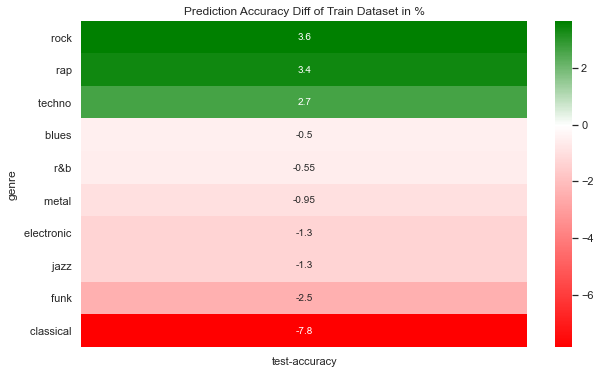

<Figure size 432x288 with 0 Axes>

In [83]:
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

fig, ax = plt.subplots(figsize=(10, 6))
_range = abs(rfc_accuracy_diff.max().max() - rfc_accuracy_diff.min().min())
zero_position = np.abs(rfc_accuracy_diff.min().min()) / _range
color_map_list = [(0, 'red'), (zero_position, 'white'), (1.0, "green")]

cmap = LinearSegmentedColormap.from_list('custom_cmap', color_map_list)
sns.heatmap(rfc_accuracy_diff, annot=True, cmap=cmap, annot_kws={'fontsize': 10})
plt.title("Prediction Accuracy Diff of Train Dataset in %")
plt.figure()